## Импорт данных
Для работы были выбраны следующие датасеты:

1. Bitcoin Alpha: http://konect.cc/networks/soc-sign-bitcoinalpha/

2. Manufacturing Emails: http://konect.cc/networks/radoslaw_email/

3. Chess: http://konect.cc/networks/chess/

4. UC Irvine messages: http://konect.cc/networks/opsahl-ucsocial/

5. Digg: http://konect.cc/networks/munmun_digg_reply/

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from random import sample
from random import choices
from math import exp, sqrt
import csv
import json
from prettytable import PrettyTable

#### Инициализация графа средствами pandas

In [2]:
dataset = 4
names = ['Bitcoin', 'Emails', 'Chess', 'Ucsocial', 'Digg']

In [3]:
# choose dataset
datasets = ['soc-sign-bitcoinalpha', 'radoslaw_email_email', 'chess', 'opsahl-ucsocial', 'munmun_digg_reply']
filepath = filepath = "./datasets/out." + datasets[dataset]

# define graph as dataframe structure
headers = ["ID_of_from_node","ID_of_to_node", "weight", "timestamp"]
Graph = pd.read_csv(filepath, comment='%', names=headers, sep=' ', index_col=False).drop_duplicates()

# define number of vertices
V=np.unique((Graph['ID_of_from_node']._append(Graph['ID_of_to_node'])).values).astype(int)
V_num = V.size

#### Генерация списка смежности
Происходит либо импортированием уже ранее сгенерированного списка смежности, либо генерируется и записывается в файл

In [4]:
# export/import generated adjacency list with whitespaces separators
adj_lists = ['adj-bitcoinalpha.csv', 'adj-email.csv', 'adj-chess.csv', 'adj-ucsocial.csv', 'adj-digg.csv']
filename = adj_lists[dataset]

Импортирование уже существующего списка смежности:

In [ ]:
def import_adj():
    matrix = {}
    filepath = "./adj-lists/" + filename

    with open(filepath, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        
        for row in reader:
            node = int(row[0])
            adjacent = set(int(row[i]) for i in range(1, len(row)))
            matrix[node] = adjacent

    return matrix

matrix = import_adj()

Генерация списка смежности и его экспорт:

In [5]:
def export_adj():
    filepath = "./adj-lists/" + filename

    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ')

        for node in V:
            writer.writerow([node] + ([] if node not in matrix.keys() else list(matrix[node])))

In [6]:
# generate adjacency list for new dataset - new method
matrix = {}

def add_adjacent(node, adj):
    if node not in matrix:
        adjacent = set()
        adjacent.add(adj)
        matrix[node] = adjacent
    else:
        matrix[node].add(adj)

for u, v, w, t in Graph.itertuples(index=False):
    if u == v: # to skip loops (in case they're present), because dissartotivity degree formula is 2m/n(n-1) (according to paper)
        continue
    
    add_adjacent(u, v)
    add_adjacent(v, u)

export_adj()

## Часть 1: свойства сетей (для статического графа)

#### Задание 1: базовые характеристики

In [29]:
E_num = 0
for i in V:
    if i not in matrix.keys():
        continue
    
    for s in matrix[i]:
        if s>i:
            E_num+=1

density = 2*E_num/(V_num*(V_num-1))
print(f'Количество вершин: {V_num};\nКоличество ребер: {E_num};\nПлотность: {density}')

Количество вершин: 30398;
Количество ребер: 85155;
Плотность: 0.00018431658480673382


#### Задание 2
Определение компонент слабой свзности и метрик расстояния

In [33]:
loops_only = set()

for v in V:
    if v not in matrix.keys():
        loops_only.add(v)

In [35]:
visited = set(V).difference(loops_only)
Component = set()
answer = 0

while len(visited):
    answer += 1
    v = visited.pop()
    comp = set([v])
    candidates = matrix[v].copy()
    while len(candidates):
        newCan = set()
        for i in candidates:
            newCan.update(matrix[i])
        comp.update(candidates)
        candidates = newCan.difference(comp)
    visited -= comp
    if len(comp) > len(Component):
        Component = comp.copy()

WC_prop = len(Component)/V_num

print(f'Количество компонент слабой связности: {answer};\nРазмер максимальной компоненты: {len(Component)};\nДоля вершин в максимальной компоненте: {WC_prop}' )

Количество компонент слабой связности: 335;
Размер максимальной компоненты: 29652;
Доля вершин в максимальной компоненте: 0.9754589117705112


Вычисление матрицы расстояний для некоторого подграфа:

In [36]:
def Path_matrix_calc(subGraph : set):
    Path_matrix = {
        _from: {
             _to: V_num+1 if _from !=_to else 0
            for _to in subGraph
        }
    for _from in subGraph
    }

    V_calculated = set()
    for a in subGraph:
        V_calculated.add(a)
        V_to_calculate = (subGraph.copy()).difference(V_calculated)
        Visited = set()
        queue = [a]
        dists_queue = {a:0}
        while queue and V_to_calculate:
            u = queue.pop(0)
            dist = dists_queue.pop(u)
            Visited.add(u)
            u_visit = matrix[u].difference(Visited)
            for v in u_visit:
                if v in V_to_calculate:
                    if dist + 1 < Path_matrix[a][v]:
                        Path_matrix[a][v] = dist + 1
                        Path_matrix[v][a] = dist + 1
                        V_to_calculate.discard(v)
                if v not in dists_queue:
                    queue.append(v)
                    dists_queue[v]=dist+1
    return(Path_matrix)

Вычисление метрик расстояния.

Path_matrix позволяет нам получить информацию об эксцентриситете для каждой вершины.

Радиус - минимальное значение эксцентриситета; диаметр - максимальное.

In [37]:
def Radius_Diametr_Proc(Path_matrix, subGraph: set):
    Exentr = [max(Path_matrix[node].values()) for node in subGraph]
    Radius = min(Exentr)
    Diametr = max(Exentr)
    Distances=[]
    visited = set()
    for i in subGraph:
        visited.add(i)
        for j in subGraph:
            if j not in visited:
                Distances.append(Path_matrix[i][j])
    Distances.sort()
    # Proc_90 = Distances[int(0.9*len(Distances))]
    Proc_90 = np.percentile(Distances, 90)
    return(Radius, Diametr, Proc_90)

In [38]:
def txt_write(name, matrix, subGraph):
    with open(f'distance-lists\{name}', 'w') as f:
        f.write(str(subGraph))
        f.write('\n')
        f.write(json.dumps(matrix))

Задание А: оценка расстояний для 500 случайно выбранных вершин из наибольшей компоненты слабой связности (Component)

In [39]:
dist_infos_a = ['a-pathmat-bitcoinalpha.txt', 'a-pathmat-email.txt', 'a-pathmat-chess.txt', 'a-pathmat-ucsocial.txt', 'a-pathmat-digg.txt']
dist_infos_b = ['b-pathmat-bitcoinalpha.txt', 'b-pathmat-email.txt', 'b-pathmat-chess.txt', 'b-pathmat-ucsocial.txt', 'b-pathmat-digg.txt']

cur_a = dist_infos_a[dataset]
cur_b = dist_infos_b[dataset]

In [40]:
subGraph_a = set(sample(list(Component), k=500)) # check k !!!!!!!!!!!!!!
Path_matrix_a = Path_matrix_calc(subGraph_a)
txt_write(cur_a, Path_matrix_a, subGraph_a)
Radius_a, Diametr_a, Proc_90_a = Radius_Diametr_Proc(Path_matrix_a, subGraph_a)
print(f'Радиус: {Radius_a};\nДиаметр: {Diametr_a};\n90 процентиль расстояния: {Proc_90_a};')

Радиус: 6;
Диаметр: 10;
90 процентиль расстояния: 6.0;


Задание B: оценка расстояний методом "снежный ком"

In [41]:
subGraph_b = set(sample(list(Component), k=2)) # check k !!!!!!!!!!!!!
nodes = subGraph_b.copy()
while len(subGraph_b)<500 and len(nodes)>0:
    u = nodes.pop()
    for i in matrix[u]:
        if len(subGraph_b) == 500:
            break
        nodes.add(i)
        subGraph_b.add(i)
Path_matrix_b = Path_matrix_calc(subGraph_b)
txt_write(cur_b, Path_matrix_b, subGraph_b)
Radius_b, Diametr_b, Proc_90_b = Radius_Diametr_Proc(Path_matrix_b, subGraph_b)
print(f'Радиус: {Radius_b};\nДиаметр: {Diametr_b};\n90 процентиль расстояния: {Proc_90_b};')

Радиус: 4;
Диаметр: 6;
90 процентиль расстояния: 4.0;


#### Задание 3
Вычисление среднего кластерного коэффициента сети для наибольшей компоненты слабой связности

In [45]:
def Cl(u):
    if len(matrix[u])<2:
        return 0
    neib = matrix[u]
    G = len(neib)
    _2L=0
    for our in neib:
        _2L+=len(matrix[our].intersection(neib))
    return _2L/(G*(G-1))

CL = 0
for node in Component:
    CL+=Cl(node)

Acc = CL/V_num
print(f'средний кластерный коэффициент сети: {Acc}')

средний кластерный коэффициент сети: 0.00528633336069672


#### Задание 4
Вычисление коэффициента ассортативности

In [43]:
# Задание 4
V = set(V).difference(loops_only)

def R():
    r1, r2, r3, re = 0, 0, 0, 0
    for node in V:
        u = len(matrix[node])
        r1+=u
        r2+=u*u
        r3+=u*u*u
        for to in matrix[node]:
            re+=u*len(matrix[to])
    return (re*r1-r2*r2)/(r3*r1-r2*r2)

r = R()
print(f'Коэффициент ассортативности: {r}')

Коэффициент ассортативности: 0.004633875688855631


In [48]:
stats = PrettyTable()
stats.field_names = ['Dataset', '|V|', '|E|', 'Density', 'D.a.', 'A.c.c.', 'Diam-A', 'Diam-B', 'WC-num', 'WC-prop']

stats.add_row([names[dataset], V_num, E_num, round(density, 4), round(r, 3), round(Acc, 3), Diametr_a, Diametr_b, answer, round(WC_prop, 3)])

with open('stats\stats.txt', 'a') as w:
    w.write(str(stats) + '\n')

## Часть 2

#### Часть А
Вычисление статических и темпоральных признаков сети (I, II-A)

In [8]:
import sklearn
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from scipy import integrate
# from sklearn.model_selection import train_test_split # not using anymore

Подготовка временных отрезков для вычисления темпоральных признаков и решения задачи предсказания:

In [9]:
t_min = Graph['timestamp'].min()
t_max = Graph['timestamp'].max()
s = (t_max-t_min) * 0.66 + t_min

print(f'Timestamp_min: {t_min}')
print(f'Timestamp_max: {t_max}')
print(f'Separator: {s}')

Timestamp_min: 1225229529
Timestamp_max: 1226536024
Separator: 1226091815.7


Подготовка к вычислению темпоральных признаков. Поскольку здесь работаем уже с темпоральным графом, то важно учитывать, что между одной парой вершин (u, v) могут существовать несколько рёбер с разными временными метками. С этой целью создаётся словарь словарей: 

- для внешнего словаря: ключи - все вершины рассматриваемого графа; значения - словарь из смежных с u вершин в промежутке [t_min, s]

- для внутреннего словаря: ключ - вершина; значения - множество рёбер, появившихся между (u, v) в промежутке [t_min, s]

In [10]:
# create adjacency list with timestamps:
matrix_t = dict()

for u in V:
    matrix_t[u] = dict()

def add_time (parent, child, timestamp):
    if child in matrix_t[parent]:
        matrix_t[parent][child].add(timestamp)
    else:
        timeset = set()
        timeset.add(timestamp)
        matrix_t[parent][child] = timeset

for u, v, w, t in Graph.itertuples(index=False):
    # u = _1 # int(row['ID of from node'])
    # v = _2 # int(row['ID of to node'])
    #timestamp = timestamp#int(row['timestamp'])

    if u == v: # skip loops
        continue

    if t <= s: # work only with data from [t0, s]
        add_time(u, v, t)
        add_time(v, u, t)

Подготовка множества потенциальных пар вершин, которые будут использоваться в задаче бинарной классификации. В соответствии с рекомендациями статьи, в качестве потенциальных пар будем рассматривать только такие пары вершин, что находятся на расстоянии 2 в промежутке [t_min, s]

In [11]:
# choose potential pairs
# (u, v) with distance 2 (so they're not connected in [t0, s])
potential_pairs = set()

for u in V:
    u_adj = set(matrix_t[u].keys())
    for v in V:
        v_adj = set(matrix_t[v].keys())
        if u not in matrix_t[v].keys() and u_adj.intersection(v_adj):
            if u < v:
                potential_pairs.add((u, v))

Разделим множество потенциальных пар на:

- positive_pairs: состоит только из пар вершин, которые соединятся в будущем

- negative_pairs: состоит только из пар вершин, которые не соединятся в будущем

In [12]:
# take all yes/no pairs from potential pairs
positive_pairs = set() # all node pairs that will connect
negative_pairs = set() # all node pairs that will not connect

for u, v in potential_pairs:
    if v in matrix[u]:
        positive_pairs.add((u, v))

negative_pairs = potential_pairs.difference(positive_pairs)

Выберем 20.000 пар вершин для вычисления векторов-признаков и обучения модели линейной регрессии

In [13]:
# choose samples with replacement
samples_num = 10000

In [14]:
positive_samples = choices(list(positive_pairs), k=samples_num)
negative_samples = choices(list(negative_pairs), k=samples_num)

Вычисление Static Topological Features (I) для выбранных пар

In [15]:
def calculate_vector_s(pair):
    parent, child = pair

    parent_adj = set(matrix_t[parent].keys())
    child_adj = set(matrix_t[child].keys())
    commons = parent_adj.intersection(child_adj)

    res = [0 for i in range(4)]

    res[0] = len(commons) # CN_s
    res[2] = len(commons) / len(parent_adj.union(child_adj)) # JC_s
    res[3] = len(parent_adj) * len(child_adj) # PA_s

    # AA_s
    for z in commons:
        z_adj = len(set(matrix_t[z].keys()))

        if z_adj == 1:
            res[1] += 0
            continue

        res[1] += 1 / np.log10(z_adj)

    return res

In [16]:
# Temporal features with past event aggreagtion (II-A)
# Step C: weighted topological features for chosen samples only;
X_positive_s = [[] for i in range(samples_num)]
# labels_positive = []

X_negative_s = [[] for i in range(samples_num)]
# lables_negative = []

for i in range(samples_num):
    X_positive_s[i] = calculate_vector_s(positive_samples[i])
    X_negative_s[i] = calculate_vector_s(negative_samples[i])

shuffle(X_positive_s)
shuffle(X_negative_s)

Вычисление темпоральных признаков для пары вершин с случае II-A состоит из 3 этапов:

1. Temporal weighting

2. Past event aggregation

3. Computation of weighted topological features

Вычисление весов для рёбер:

In [17]:
# Step A: temporal weighting
l = 0.2 # same value as in paper

def weight_linear(times):
    weights = set()
    for t in times:
        T = (t - t_min) / (s - t_min)
        weights.add(l + (1 - l) * T)
    
    return weights

def weight_exp(times):
    weights = set()
    for t in times:
        T = (t - t_min) / (s - t_min)
        weights.add(l + (1 - l) * ((exp(3 * T) - 1) / (exp(3) - 1)))

    return weights

def weight_square(times):
    weights = set()
    for t in times:
        T = (t - t_min) / (s - t_min)
        weights.add(l + (1 - l) * sqrt(T))
    
    return weights

У каждой пары вершин есть некоторое множество весов. Далее мы переходим к шагу 2, где агрегируем их для получение одной оценки для пары вершин (u, v) 8-ю разными способами:

In [18]:
# Temporal features with past event aggreagtion (II-A)
# Step B: past event aggregation
def aggregate(weights):
    # q-quantiles are values that partition a finite set of values into q subsets of (nearly) equal sizes
    warr = np.array(list(weights))

    zeroth = warr.min() # 0th quantile = minimum
    first = warr.max() # 1st quantile = maximum
    second = np.median(warr) # 2nd quantile = median
    third = np.quantile(warr, 0.3) # 3rd quantile = tertile
    fourth = np.quantile(warr, 0.25) # 4th quantile = quartile

    sum = np.sum(warr)
    mean = np.mean(warr)
    variance = np.var(warr)

    return [zeroth, first, second, third, fourth, sum, mean, variance]

Инициализация словаря, ключи которого - пары вершин (u, v), а значения - массив из агрегированных оценок шага 2:

In [19]:
# Temporal features with past event aggreagtion (II-A)
# dict-like structure initialization (aggregated): (node1, node2): [zeroth_linear, ..., variance_linear, zeroth_exp, ..., variance_exp, zeroth_sqrt, ..., variance_sqrt]
aggregated = dict()

for node in sorted(V):
    for adj in matrix_t[node]:
        if adj > node:
            # convert set of timestamps into set of weights according to formulas
            linear = weight_linear(matrix_t[node][adj])
            exponent = weight_exp(matrix_t[node][adj])
            square = weight_square(matrix_t[node][adj])

            res = aggregate(linear)
            res += aggregate(exponent)
            res += aggregate(square)

            aggregated[(node, adj)] = res

Реализация шага 3: вычисление weighted topological features, которые станут векторами-признаками для пар вершин в задаче бинарной классификации:

In [20]:
def get_aggregated(node, z, cat):
    return aggregated[(node, z)][cat] if node < z else aggregated[(z, node)][cat]

def calculate_vector(pair):
    parent, child = pair

    parent_adj = set(matrix_t[parent].keys())
    child_adj = set(matrix_t[child].keys())
    commons = parent_adj.intersection(child_adj)

    res = []

    for category in range(24):
        AA_tmp, CN_tmp, JC_tmp = 0, 0, 0
        AA_check, JC_check = False, False

        for z in commons:
            # common part for AA, CN, JC
            num = get_aggregated(parent, z, category)
            num += get_aggregated(child, z, category)

            # Find AA_tmp
            if AA_check == False:
                AA_denum = 1

                for x in matrix_t[z].keys():
                    AA_denum += get_aggregated(z, x, category)

                if AA_denum == 1:
                    AA_check = True
                else:
                    AA_tmp += num / np.log10(AA_denum)

            # Find CN_tmp
            CN_tmp += num

            # Find JC_tmp
            if JC_check == False:
                JC_denum = 0

                for x in matrix_t[parent].keys():
                    JC_denum += get_aggregated(parent, x, category)
                for x in matrix_t[child].keys():
                    JC_denum += get_aggregated(child, x, category)
                
                if JC_denum == 0:
                    JC_check = True
                else:
                    JC_tmp += num / JC_denum

        # Find PA_tmp
        ares, bres = 0, 0

        for a in matrix_t[parent].keys():
            ares += get_aggregated(parent, a, category)
        for b in matrix_t[child].keys():
            bres += get_aggregated(child, b, category)
    
        PA_tmp = ares * bres

        # Results for current category:
        res.append(AA_tmp if AA_check == False else 0)
        res.append(CN_tmp)
        res.append(JC_tmp if JC_check == False else 0)
        res.append(PA_tmp)
    
    return res

#### Часть B

Вычисляем векторы-признаки, используя темпоральные признаки

In [21]:
# Temporal features with past event aggreagtion (II-A)
# Step C: weighted topological features for chosen samples only;
X_positive_t = [[] for i in range(samples_num)]

X_negative_t = [[] for i in range(samples_num)]

for i in range(samples_num):
    X_positive_t[i] = calculate_vector(positive_samples[i])
    X_negative_t[i] = calculate_vector(negative_samples[i])

shuffle(X_positive_t)
shuffle(X_negative_t)

Для решения задачи бинарной классификации, необходимо разделить изначальные 10.000 пар на 2 подмножества: train, на которых обучится алгоритм, и test для оценки результатов обучения

In [22]:
# separate calculated feature vectors into 2 groups: train (for learning) and test (for prediction)
border = round(samples_num * 0.75)

# train/test with static features
X_train_s = X_positive_s[:border] + X_negative_s[:border]
y_train_s = np.array([1] * border + [0] * border)

X_test_s = X_positive_s[border:] + X_negative_s[border:]
y_test_s = np.array([1] * (samples_num-border) + [0] * (samples_num-border))

# train/test with temporal features
X_train_t = X_positive_t[:border] + X_negative_t[:border]
y_train_t = np.array([1] * border + [0] * border)

X_test_t = X_positive_t[border:] + X_negative_t[border:]
y_test_t = np.array([1] * (samples_num-border) + [0] * (samples_num-border))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [23]:
# make instance of model
logisticRegr_s = LogisticRegression(max_iter=2000)
logisticRegr_t = LogisticRegression(max_iter=10000)

# train model: learning the relationship between feature vectors (X_train) and labels (y_train)
logisticRegr_s.fit(X_train_s, y_train_s)
logisticRegr_t.fit(X_train_t, y_train_t)

LogisticRegression(max_iter=10000)

In [24]:
# predict
# Predict for One Observation (image)
answer_prob_s = logisticRegr_s.predict_proba(X_test_s)
answer_prob_t = logisticRegr_t.predict_proba(X_test_t)

answer_class_s = logisticRegr_s.predict(X_test_s)
answer_class_t = logisticRegr_t.predict(X_test_t)

Метрики качества и сравнения

In [25]:
from sklearn import metrics

In [26]:
basic_metrics = PrettyTable()
basic_metrics.field_names = ['Dataset', 'Features', 'Accuracy', 'Precision', 'Recall']

basic_metrics.add_row([names[dataset], 'static', metrics.accuracy_score(answer_class_s, y_test_s),
                        metrics.precision_score(answer_class_s, y_test_s), metrics.recall_score(answer_class_s, y_test_s)])
basic_metrics.add_row([names[dataset], 'temporal', metrics.accuracy_score(answer_class_t, y_test_t),
                        metrics.precision_score(answer_class_t, y_test_t), metrics.recall_score(answer_class_t, y_test_t)])

with open('stats\metrics.txt', 'a') as w:
    w.write(str(basic_metrics) + '\n')

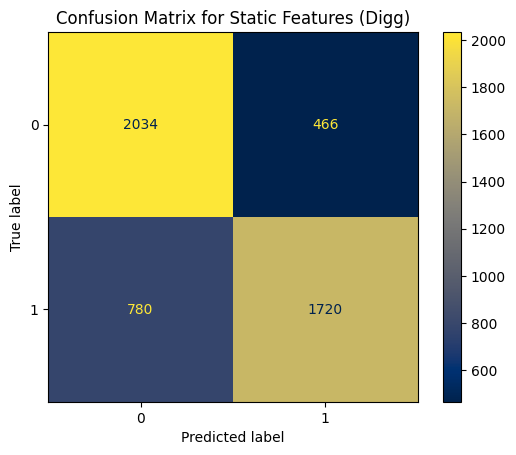

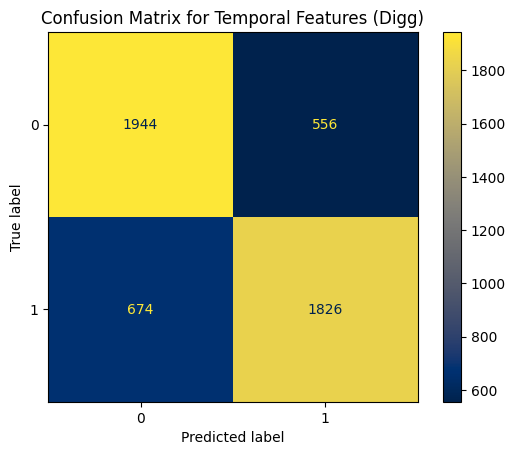

In [27]:
cm_s = metrics.confusion_matrix(y_test_s, answer_class_s)
cm_display_s = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_s)
cm_display_s.plot(cmap='cividis')
plt.title(f'Confusion Matrix for Static Features ({names[dataset]})')
plt.show()

cm_t = metrics.confusion_matrix(y_test_t, answer_class_t)
cm_display_t = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_t)
cm_display_t.plot(cmap='cividis')
plt.title(f'Confusion Matrix for Temporal Features ({names[dataset]})')
plt.show()

Построение ROC-AUC кривой

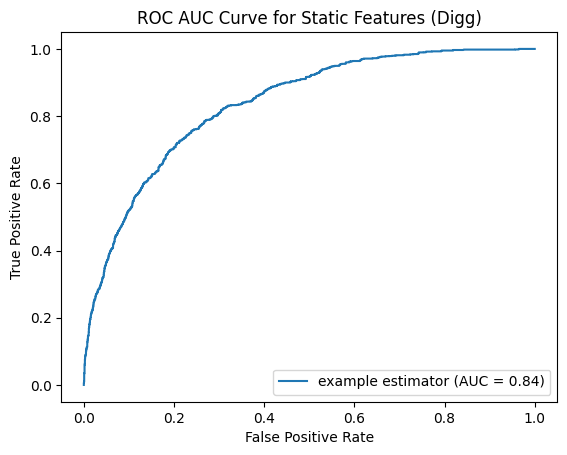

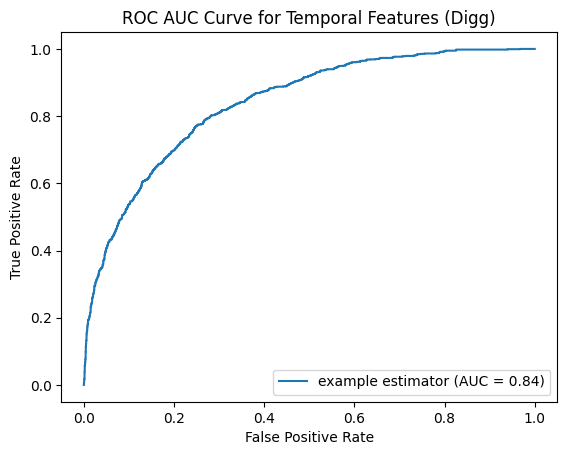

In [28]:
fpr_s, tpr_s, thresholds_s = metrics.roc_curve(y_test_s, answer_prob_s[:, 1])
roc_auc_s = metrics.auc(fpr_s, tpr_s)
roc_display_s = metrics.RocCurveDisplay(fpr=fpr_s, tpr=tpr_s, roc_auc=roc_auc_s, estimator_name='example estimator')
roc_display_s.plot()
plt.title(f'ROC AUC Curve for Static Features ({names[dataset]})')
plt.show()

fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test_t, answer_prob_t[:, 1])
roc_auc_t = metrics.auc(fpr_t, tpr_t)
roc_display_s = metrics.RocCurveDisplay(fpr=fpr_t, tpr=tpr_t, roc_auc=roc_auc_t, estimator_name='example estimator')
roc_display_s.plot()
plt.title(f'ROC AUC Curve for Temporal Features ({names[dataset]})')
plt.show()

In [ ]:
# def FRP_TPR(limit, answer_, Ytest):
#     FP, TN, TP, FN = 0, 0, 0, 0
#     for i in range(len(answer_)):
#         if answer_[i]>=limit and Ytest[i]==1:
#             TP+=1
#         elif answer_[i]>=limit:
#             FP+=1
#         elif Ytest[i]==1:
#             FN+=1
#         else:
#             TN+=1
#     TPR = TP / (TP + FN)
#     FPR = FP / (FP + TN)
#     return FPR, TPR


In [ ]:
# строим график
# limit = np.linspace(0, 1, 1000)
# fpr, tpr = [], []
# for l in limit: 
#     res = FRP_TPR(l, answer, y_test)
#     fpr.append(res[0])
#     tpr.append(res[1])
# roc_auc = integrate.trapz(tpr[::-1], fpr[::-1])
# plt.plot(fpr, tpr, color='darkorange',
#          label='ROC кривая (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Пример ROC-кривой')
# plt.legend(loc="lower right")
# plt.show()